In [1]:
import numpy as np
import torch
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm

import pickle
import csv
import time
import sys

sys.path.append('src/')

# Own libraries
import utils
import trainer_WGAN as trainer
import model_WGAN
import models
import WGAN

torch.manual_seed(42)

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Encoding parameters
k = 4
n = 7
M = 16
TRAINING_SNR = 12
rate = k/n
noise_std = utils.EbNo_to_noise(TRAINING_SNR, rate)
save_every = 1000


#GAN parameters
g_input_size = 2*n      # Random noise dimension coming into generator, per output vector
g_hidden_size = 256 # Generator complexity
g_output_size = n     # Size of generated output vector

d_input_size = 2*n    # Minibatch size - cardinality of distributions
d_hidden_size = 256    # Discriminator complexity
d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification

batch_size = 5000
num_epochs = 30000

G = WGAN.Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = WGAN.Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)
G = G.to(device)
D = D.to(device)

d_lr = 5e-5
g_lr = 5e-5

channel_ray = model_WGAN.Channel_ray_only(noise_std)

In [9]:
milestone=80
G.load_state_dict(torch.load(f'state_dict_WGAN/G_Rayleigh-{milestone}.pt', map_location="cpu"))
G.eval()
G = G.to(device)


# Training GAN


In [ ]:
epochs = tqdm(range(num_epochs), ascii=True)
for epoch in epochs:
    kl, g_loss = WGAN.train_WGAN(G, D, batch_size, n, channel_ray, d_lr, g_lr)
    if (epoch+1) % 50 == 0:
        epochs.set_description(f"Epoch {epoch+1}: KL Div {kl:.3e} G loss {-g_loss:.3e}")
    if (epoch+1) % save_every == 0:
        torch.save(G.state_dict(), f'state_dict_WGAN/G_Rayleigh-{(epoch+1)//save_every}.pt')
        torch.save(D.state_dict(), f'state_dict_WGAN/D_Rayleigh-{(epoch+1)//save_every}.pt')

    #    WGAN.plot_GAN(G, 10000,M, n, channel_awgn, epoch)

Epoch 1:  


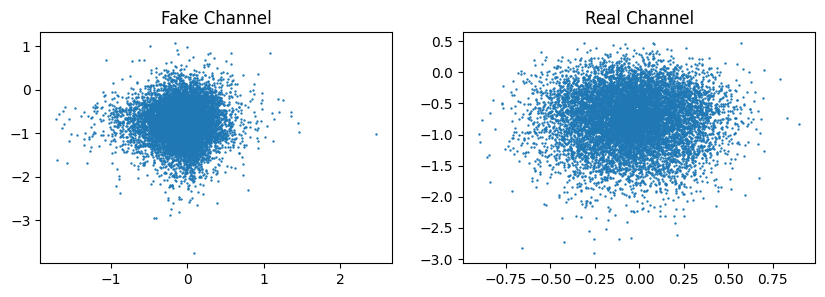

In [10]:
WGAN.plot_GAN_m(G, 10000, M, n, channel_ray, 1, device)

Epoch 49999:  


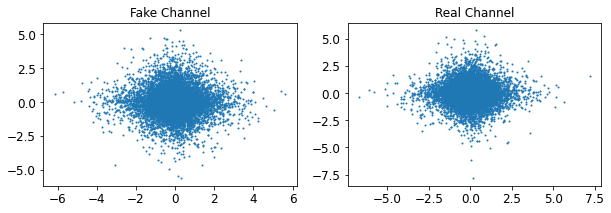

Epoch 50000: KL Div 5.324e-03 G loss -1.247e-02: 100%|######################################| 50000/50000 [3:56:31<00:00,  3.52it/s]


In [19]:
num_epochs_acc = 32000#num_epochs
num_epochs = 50000
save_every = 1000
d_lr = 1e-5
g_lr = 1e-5
epochs = tqdm(range(num_epochs), ascii=True)
for epoch in epochs:
    kl, g_loss = WGAN.train_WGAN(G, D, batch_size, n, channel_ray, d_lr, g_lr)
    if (epoch+1) % 50 == 0:
        epochs.set_description(f"Epoch {epoch+1}: KL Div {kl:.3e} G loss {-g_loss:.3e}")
    if (epoch+1) % save_every == 0:
        torch.save(G.state_dict(), f'state_dict_WGAN/G_Rayleigh-{(num_epochs_acc+epoch+1)//save_every}.pt')
        torch.save(D.state_dict(), f'state_dict_WGAN/D_Rayleigh-{(num_epochs_acc+epoch+1)//save_every}.pt')

        WGAN.plot_GAN(G, 10000,M, n, channel_ray, epoch)

## Measuring the sampling time

In [12]:
import time

# Set the message samples to test out
num_samples = 2 ** 13 # per message
#m_sample = torch.eye(M)
#m = m_sample.repeat_interleave(num_samples, dim=0)
batch_size = 1024 

#encoder = models.Encoder_1h( M, n, n).to(device)
x = torch.ones(batch_size, n).to(device) 
t = time.time() # tic

#m_batched = torch.split(m, batch_size)
#for m_b in m_batched:
for i in range(num_samples // batch_size):
    #m_b = m_b.to(device)
    #x = encoder(m_b)
    x_seq = G(x)
    #samples_DDPM = x_seq[-1]
sampling_time_WGAN = time.time() - t # toc
print(sampling_time_WGAN)


0.0015850067138671875


# Training GAN Encoder

In [13]:
dataset = np.random.randint(0,M, size=10000000)

In [14]:
encoder_GAN = models.Encoder_1h( M, n, n)
decoder_GAN = models.Decoder_1h( M, n)

In [15]:
encoder_GAN.load_state_dict(torch.load('state_dict_WGAN/enc_GAN_Rayleigh.pt', map_location="cpu"))
decoder_GAN.load_state_dict(torch.load('state_dict_WGAN/dec_GAN_Rayleigh.pt', map_location="cpu"))
encoder_GAN.eval()
decoder_GAN.eval()

Decoder_1h(
  (_f): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=16, out_features=16, bias=True)
  )
)

In [8]:
channel = model_WGAN.Channel_GAN(encoder_GAN, decoder_GAN, G).to(device)
tconf = trainer.TrainerConfig(max_epochs=10, noise_std = noise_std, batch_size=1000, M=M,
                              learning_rate=1e-3, rate=rate)
weights = filter(lambda p: p.requires_grad, list(encoder_GAN.parameters())+list(decoder_GAN.parameters()))
t_gan = trainer.Trainer(channel, dataset, tconf, one_hot=True)
t_gan.train(weights=weights, GAN=True, global_epoch=0)

epoch 10: loss 8.85e-03 SER 2.75e-03: 100%|###################################################| 10000/10000 [01:58<00:00, 84.13it/s]


In [20]:
channel = model_WGAN.Channel_GAN(encoder_GAN, decoder_GAN, G).to(device)
tconf = trainer.TrainerConfig(max_epochs=20, noise_std = noise_std, batch_size=1000, M=M,
                              learning_rate=1e-3, rate=rate)
weights = filter(lambda p: p.requires_grad, list(encoder_GAN.parameters())+list(decoder_GAN.parameters()))
t_gan = trainer.Trainer(channel, dataset, tconf, one_hot=True)
t_gan.train(weights=weights, GAN=True)

epoch 20: loss 5.75e-03 SER 1.87e-03: 100%|###################################################| 10000/10000 [02:26<00:00, 68.30it/s]


In [21]:
channel = model_WGAN.Channel_GAN(encoder_GAN, decoder_GAN, G).to(device)
tconf = trainer.TrainerConfig(max_epochs=20, noise_std = noise_std, batch_size=1000, M=M,
                              learning_rate=1e-4, rate=rate)
weights = filter(lambda p: p.requires_grad, list(encoder_GAN.parameters())+list(decoder_GAN.parameters()))
t_gan = trainer.Trainer(channel, dataset, tconf, one_hot=True)
t_gan.train(weights=weights, GAN=True)

epoch 20: loss 5.50e-03 SER 1.80e-03: 100%|###################################################| 10000/10000 [02:12<00:00, 75.25it/s]


In [22]:
torch.save(encoder_GAN.state_dict(), 'state_dict_WGAN/enc_GAN_Rayleigh.pt')
torch.save(decoder_GAN.state_dict(), 'state_dict_WGAN/dec_GAN_Rayleigh.pt')

In [17]:
channel.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

# Training AE Encoder

In [12]:
encoder_AE = models.Encoder_1h( M, n, n)
decoder_AE = models.Decoder_1h( M, n)
model_2 = model_WGAN.Channel_GAN(encoder_AE, decoder_AE, channel_ray).to(device)
#model_2 = model_WGAN.Channel(encoder_AE, decoder_AE).to(device)

tconf = trainer.TrainerConfig(max_epochs=10, noise_std = noise_std, batch_size=1000, M=M, rate=rate)
weights = filter(lambda p: p.requires_grad, model_2.parameters())

t_ae = trainer.Trainer(model_2, dataset, tconf, one_hot=True)
t_ae.train(weights=weights, GAN=True)

epoch 1: loss 6.58e-02 SER 1.73e-02: 100%|#| 10000/10000 [00:54<00:00, 181.94it/
epoch 2: loss 1.59e-02 SER 5.43e-03: 100%|#| 10000/10000 [00:43<00:00, 228.88it/
epoch 3: loss 1.13e-02 SER 3.85e-03: 100%|#| 10000/10000 [00:40<00:00, 247.22it/
epoch 4: loss 1.04e-02 SER 3.55e-03: 100%|#| 10000/10000 [00:44<00:00, 226.42it/
epoch 5: loss 9.77e-03 SER 3.34e-03: 100%|#| 10000/10000 [00:38<00:00, 262.92it/
epoch 6: loss 8.78e-03 SER 2.99e-03: 100%|#| 10000/10000 [00:46<00:00, 217.20it/
epoch 7: loss 8.06e-03 SER 2.76e-03: 100%|#| 10000/10000 [00:47<00:00, 210.98it/
epoch 8: loss 7.82e-03 SER 2.68e-03: 100%|#| 10000/10000 [00:48<00:00, 206.83it/
epoch 9: loss 7.57e-03 SER 2.58e-03: 100%|#| 10000/10000 [00:53<00:00, 185.20it/
epoch 10: loss 7.43e-03 SER 2.54e-03: 100%|#| 10000/10000 [00:54<00:00, 184.72it


In [27]:
model_2 = model_WGAN.Channel_GAN(encoder_AE, decoder_AE, channel_ray).to(device)

tconf = trainer.TrainerConfig(max_epochs=20, noise_std = noise_std, batch_size=1000, 
                              learning_rate=1e-4, M=M, rate=rate)
weights = filter(lambda p: p.requires_grad, model_2.parameters())

t_ae = trainer.Trainer(model_2, dataset, tconf, one_hot=True)
t_ae.train(weights=weights, GAN=True)

epoch 20: loss 6.61e-03 SER 2.26e-03: 100%|##################################################| 10000/10000 [01:07<00:00, 148.35it/s]


In [30]:
model_2 = model_WGAN.Channel_GAN(encoder_AE, decoder_AE, channel_ray).to(device)

tconf = trainer.TrainerConfig(max_epochs=40, noise_std = noise_std, batch_size=1000, 
                              learning_rate=1e-4, M=M, rate=rate)
weights = filter(lambda p: p.requires_grad, model_2.parameters())

t_ae = trainer.Trainer(model_2, dataset, tconf, one_hot=True)
t_ae.train(weights=weights, GAN=True)

epoch 40: loss 6.47e-03 SER 2.22e-03: 100%|##################################################| 10000/10000 [01:10<00:00, 140.88it/s]


# Testing AE & GAN Encoder under real channel

In [ ]:
dataset = np.random.randint(0,M, size=10000000)

In [ ]:
bler_testGAN =[]
#ebno_range = [4,5,6,7,8]
ebno_range = [*range(1,25+1)] # [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
 
model_testGAN = model_WGAN.Channel_ray(encoder_GAN, decoder_GAN).to(device)
tconf = trainer.TrainerConfig(max_epochs=5, noise_std = noise_std, batch_size=1000, M=M, rate=rate)

t_testGAN = trainer.Trainer(model_testGAN, dataset, tconf, one_hot=True)


bler_testGAN = t_testGAN.test(snr_range=ebno_range, one_hot=True, erasure_bound=0.7)

SNR 22  iter 9900: SER 2.260e-04: 100%|##| 10000/10000 [00:17<00:00, 581.28it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 23  iter 9900: SER 1.856e-04: 100%|##| 10000/10000 [00:17<00:00, 572.08it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 24  iter 9900: SER 1.776e-04: 100%|##| 10000/10000 [00:17<00:00, 574.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 24  iter 9900: SER 1.560e-04: 100%|##| 10000/10000 [00:16<00:00, 621.27it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 25  iter 9900: SER 1.444e-04: 100%|##| 10000/10000 [00:14<00:00, 673.78it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 25  iter 2800: SER 1.432e-04:  29%|8  | 2872/10000 [00:04<00:10, 687.31it/s]

In [13]:
bler_testGAN =[]
#ebno_range = [4,5,6,7,8]
ebno_range = [*range(1,25+1)] # [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
 
model_testGAN = model_WGAN.Channel_ray(encoder_GAN, decoder_GAN).to(device)
tconf = trainer.TrainerConfig(max_epochs=5, noise_std = noise_std, batch_size=1000, M=M, rate=rate)

t_testGAN = trainer.Trainer(model_testGAN, dataset, tconf, one_hot=True)


bler_testGAN = t_testGAN.test(snr_range=ebno_range, one_hot=True, erasure_bound=0.7)

SNR 22  iter 9900: SER 2.249e-04: 100%|##| 10000/10000 [00:35<00:00, 281.50it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 23  iter 9900: SER 1.870e-04: 100%|##| 10000/10000 [00:35<00:00, 284.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 24  iter 9900: SER 1.646e-04: 100%|##| 10000/10000 [00:35<00:00, 280.28it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 24  iter 9900: SER 1.654e-04: 100%|##| 10000/10000 [00:35<00:00, 281.10it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 25  iter 9900: SER 1.436e-04: 100%|##| 10000/10000 [00:35<00:00, 279.74it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 25  iter 9900: SER 1.540e-04: 100%|##| 10000/10000 [00:35<00:00, 282.62it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 25  iter 9900: SER 1.492e-04: 100%|##| 10000/10000 [00:35<00:00, 281.90it/s]


In [16]:
bler_testAE =[]

model_testAE = model_WGAN.Channel_ray(encoder_AE, decoder_AE).to(device)
tconf = trainer.TrainerConfig(max_epochs=5, noise_std = noise_std, batch_size=1000, M=M, rate=rate)
t_testAE = trainer.Trainer(model_testAE, dataset, tconf, one_hot=True)
bler_testAE = t_testAE.test(snr_range=ebno_range, one_hot=True, erasure_bound=0.7)

SNR 16  iter 9900: SER 2.352e-04: 100%|##| 10000/10000 [00:22<00:00, 439.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 17  iter 9900: SER 1.354e-04: 100%|##| 10000/10000 [00:22<00:00, 437.49it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 17  iter 9900: SER 1.371e-04: 100%|##| 10000/10000 [00:19<00:00, 507.59it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 18  iter 9900: SER 8.444e-05: 100%|##| 10000/10000 [00:19<00:00, 517.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 18  iter 9900: SER 8.676e-05: 100%|##| 10000/10000 [00:19<00:00, 513.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 18  iter 9900: SER 8.040e-05: 100%|##| 10000/10000 [00:19<00:00, 516.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 18  iter 9900: SER 8.080e-05: 100%|##| 10000/10000 [00:19<00:00, 520.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 18  iter 9900: SER 8.181e-05: 100%|##| 10000/10000 [00:19<00:00, 506.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 19  iter 9900: SER 5.807e-05: 100%|##| 10000/10000 [00:19<00:00, 520.86it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 19  iter 9900: SER 5.262e-05: 100%|##| 10000/10000 [00:19<00:00, 521.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 19  iter 9900: SER 5.111e-05: 100%|##| 10000/10000 [00:19<00:00, 517.41it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 19  iter 9900: SER 5.484e-05: 100%|##| 10000/10000 [00:19<00:00, 519.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 19  iter 9900: SER 5.262e-05: 100%|##| 10000/10000 [00:19<00:00, 518.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 19  iter 9900: SER 5.222e-05: 100%|##| 10000/10000 [00:19<00:00, 519.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 19  iter 9900: SER 5.242e-05: 100%|##| 10000/10000 [00:19<00:00, 521.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 19  iter 9900: SER 4.949e-05: 100%|##| 10000/10000 [00:19<00:00, 518.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 20  iter 9900: SER 3.717e-05: 100%|##| 10000/10000 [00:19<00:00, 518.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 20  iter 9900: SER 3.373e-05: 100%|##| 10000/10000 [00:19<00:00, 522.36it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 20  iter 9900: SER 3.777e-05: 100%|##| 10000/10000 [00:19<00:00, 519.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 20  iter 9900: SER 3.293e-05: 100%|##| 10000/10000 [00:19<00:00, 521.79it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 20  iter 9900: SER 3.555e-05: 100%|##| 10000/10000 [00:19<00:00, 520.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 20  iter 9900: SER 3.636e-05: 100%|##| 10000/10000 [00:19<00:00, 518.53it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 20  iter 9900: SER 3.697e-05: 100%|##| 10000/10000 [00:19<00:00, 523.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 20  iter 9900: SER 3.252e-05: 100%|##| 10000/10000 [00:19<00:00, 518.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 20  iter 9900: SER 3.454e-05: 100%|##| 10000/10000 [00:19<00:00, 520.60it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  100000000


SNR 20  iter 9900: SER 3.545e-05: 100%|##| 10000/10000 [00:19<00:00, 519.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  110000000


SNR 20  iter 9900: SER 3.798e-05: 100%|##| 10000/10000 [00:19<00:00, 515.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  120000000


SNR 20  iter 9900: SER 3.333e-05: 100%|##| 10000/10000 [00:19<00:00, 522.32it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  130000000


SNR 20  iter 9900: SER 3.484e-05: 100%|##| 10000/10000 [00:19<00:00, 516.78it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  140000000


SNR 21  iter 9900: SER 2.262e-05: 100%|##| 10000/10000 [00:19<00:00, 514.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 21  iter 9900: SER 2.505e-05: 100%|##| 10000/10000 [00:19<00:00, 516.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 21  iter 9900: SER 2.757e-05: 100%|##| 10000/10000 [00:19<00:00, 517.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 21  iter 9900: SER 2.575e-05: 100%|##| 10000/10000 [00:19<00:00, 512.83it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 21  iter 9900: SER 2.353e-05: 100%|##| 10000/10000 [00:19<00:00, 523.63it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 21  iter 9900: SER 2.626e-05: 100%|##| 10000/10000 [00:19<00:00, 515.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 21  iter 9900: SER 2.586e-05: 100%|##| 10000/10000 [00:19<00:00, 517.65it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 21  iter 9900: SER 2.505e-05: 100%|##| 10000/10000 [00:19<00:00, 516.20it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 21  iter 9900: SER 2.525e-05: 100%|##| 10000/10000 [00:19<00:00, 517.09it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  100000000


SNR 21  iter 9900: SER 2.192e-05: 100%|##| 10000/10000 [00:19<00:00, 517.74it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  110000000


SNR 21  iter 9900: SER 3.131e-05: 100%|##| 10000/10000 [00:19<00:00, 517.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  120000000


SNR 21  iter 9900: SER 2.848e-05: 100%|##| 10000/10000 [00:19<00:00, 516.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  130000000


SNR 21  iter 9900: SER 2.495e-05: 100%|##| 10000/10000 [00:19<00:00, 516.62it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  140000000


SNR 21  iter 9900: SER 2.747e-05: 100%|##| 10000/10000 [00:19<00:00, 514.81it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  150000000


SNR 21  iter 9900: SER 2.222e-05: 100%|##| 10000/10000 [00:19<00:00, 516.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  160000000


SNR 21  iter 9900: SER 2.555e-05: 100%|##| 10000/10000 [00:19<00:00, 515.33it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  170000000


SNR 21  iter 9900: SER 2.737e-05: 100%|##| 10000/10000 [00:19<00:00, 517.52it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  180000000


SNR 21  iter 9900: SER 2.515e-05: 100%|##| 10000/10000 [00:19<00:00, 518.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  190000000


SNR 22  iter 9900: SER 1.757e-05: 100%|##| 10000/10000 [00:19<00:00, 514.31it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 22  iter 9900: SER 1.727e-05: 100%|##| 10000/10000 [00:19<00:00, 516.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 22  iter 9900: SER 2.040e-05: 100%|##| 10000/10000 [00:19<00:00, 515.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 22  iter 9900: SER 1.757e-05: 100%|##| 10000/10000 [00:19<00:00, 514.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 22  iter 9900: SER 2.101e-05: 100%|##| 10000/10000 [00:19<00:00, 519.53it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 22  iter 9900: SER 2.060e-05: 100%|##| 10000/10000 [00:19<00:00, 514.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 22  iter 9900: SER 1.697e-05: 100%|##| 10000/10000 [00:19<00:00, 516.86it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 22  iter 9900: SER 2.010e-05: 100%|##| 10000/10000 [00:19<00:00, 511.98it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 22  iter 9900: SER 1.980e-05: 100%|##| 10000/10000 [00:19<00:00, 513.85it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  100000000


SNR 22  iter 9900: SER 1.757e-05: 100%|##| 10000/10000 [00:19<00:00, 512.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  110000000


SNR 22  iter 9900: SER 1.767e-05: 100%|##| 10000/10000 [00:19<00:00, 516.93it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  120000000


SNR 22  iter 9900: SER 1.980e-05: 100%|##| 10000/10000 [00:19<00:00, 511.36it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  130000000


SNR 22  iter 9900: SER 2.040e-05: 100%|##| 10000/10000 [00:19<00:00, 514.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  140000000


SNR 22  iter 9900: SER 1.808e-05: 100%|##| 10000/10000 [00:19<00:00, 509.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  150000000


SNR 22  iter 9900: SER 1.666e-05: 100%|##| 10000/10000 [00:19<00:00, 517.28it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  160000000


SNR 22  iter 9900: SER 1.980e-05: 100%|##| 10000/10000 [00:19<00:00, 513.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  170000000


SNR 22  iter 9900: SER 1.646e-05: 100%|##| 10000/10000 [00:19<00:00, 512.01it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  180000000


SNR 22  iter 9900: SER 1.889e-05: 100%|##| 10000/10000 [00:19<00:00, 525.77it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  190000000


SNR 22  iter 9900: SER 1.848e-05: 100%|##| 10000/10000 [00:17<00:00, 584.22it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  200000000


SNR 22  iter 9900: SER 1.767e-05: 100%|##| 10000/10000 [00:18<00:00, 553.98it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  210000000


SNR 22  iter 9900: SER 2.081e-05: 100%|##| 10000/10000 [00:20<00:00, 485.29it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  220000000


SNR 22  iter 9900: SER 1.959e-05: 100%|##| 10000/10000 [00:20<00:00, 482.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  230000000


SNR 22  iter 9900: SER 1.990e-05: 100%|##| 10000/10000 [00:20<00:00, 490.06it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  240000000


SNR 22  iter 9900: SER 1.707e-05: 100%|##| 10000/10000 [00:20<00:00, 487.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  250000000


SNR 22  iter 9900: SER 1.798e-05: 100%|##| 10000/10000 [00:20<00:00, 496.19it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  260000000


SNR 23  iter 9900: SER 1.434e-05: 100%|##| 10000/10000 [00:23<00:00, 417.22it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 23  iter 9900: SER 1.485e-05: 100%|##| 10000/10000 [00:23<00:00, 423.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 23  iter 9900: SER 1.606e-05: 100%|##| 10000/10000 [00:23<00:00, 420.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 23  iter 9900: SER 1.212e-05: 100%|##| 10000/10000 [00:24<00:00, 414.06it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 23  iter 9900: SER 1.404e-05: 100%|##| 10000/10000 [00:23<00:00, 422.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 23  iter 9900: SER 1.555e-05: 100%|##| 10000/10000 [00:23<00:00, 417.49it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 23  iter 9900: SER 1.677e-05: 100%|##| 10000/10000 [00:23<00:00, 421.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 23  iter 9900: SER 1.313e-05: 100%|##| 10000/10000 [00:23<00:00, 420.59it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 23  iter 9900: SER 1.273e-05: 100%|##| 10000/10000 [00:23<00:00, 419.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  100000000


SNR 23  iter 9900: SER 1.182e-05: 100%|##| 10000/10000 [00:21<00:00, 473.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  110000000


SNR 23  iter 9900: SER 1.414e-05: 100%|##| 10000/10000 [00:19<00:00, 507.10it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  120000000


SNR 23  iter 9900: SER 1.333e-05: 100%|##| 10000/10000 [00:19<00:00, 502.85it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  130000000


SNR 23  iter 9900: SER 1.353e-05: 100%|##| 10000/10000 [00:19<00:00, 501.27it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  140000000


SNR 23  iter 9900: SER 1.353e-05: 100%|##| 10000/10000 [00:19<00:00, 505.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  150000000


SNR 23  iter 9900: SER 1.414e-05: 100%|##| 10000/10000 [00:19<00:00, 510.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  160000000


SNR 23  iter 9900: SER 1.323e-05: 100%|##| 10000/10000 [00:19<00:00, 511.97it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  170000000


SNR 23  iter 9900: SER 1.182e-05: 100%|##| 10000/10000 [00:19<00:00, 510.01it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  180000000


SNR 23  iter 9900: SER 1.363e-05: 100%|##| 10000/10000 [00:19<00:00, 509.47it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  190000000


SNR 23  iter 9900: SER 1.222e-05: 100%|##| 10000/10000 [00:19<00:00, 505.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  200000000


SNR 23  iter 9900: SER 1.535e-05: 100%|##| 10000/10000 [00:19<00:00, 510.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  210000000


SNR 23  iter 9900: SER 1.343e-05: 100%|##| 10000/10000 [00:19<00:00, 508.64it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  220000000


SNR 23  iter 9900: SER 1.525e-05: 100%|##| 10000/10000 [00:19<00:00, 510.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  230000000


SNR 23  iter 9900: SER 1.212e-05: 100%|##| 10000/10000 [00:20<00:00, 499.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  240000000


SNR 23  iter 9900: SER 1.273e-05: 100%|##| 10000/10000 [00:20<00:00, 486.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  250000000


SNR 23  iter 9900: SER 1.485e-05: 100%|##| 10000/10000 [00:20<00:00, 494.19it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  260000000


SNR 23  iter 9900: SER 1.616e-05: 100%|##| 10000/10000 [00:22<00:00, 444.65it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  270000000


SNR 23  iter 9900: SER 1.515e-05: 100%|##| 10000/10000 [00:24<00:00, 412.28it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  280000000


SNR 23  iter 9900: SER 1.343e-05: 100%|##| 10000/10000 [00:24<00:00, 414.20it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  290000000


SNR 23  iter 9900: SER 1.545e-05: 100%|##| 10000/10000 [00:24<00:00, 416.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  300000000


SNR 23  iter 9900: SER 1.475e-05: 100%|##| 10000/10000 [00:23<00:00, 421.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  310000000


SNR 23  iter 9900: SER 1.525e-05: 100%|##| 10000/10000 [00:23<00:00, 417.19it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  320000000


SNR 23  iter 9900: SER 1.374e-05: 100%|##| 10000/10000 [00:23<00:00, 417.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  330000000


SNR 23  iter 9900: SER 1.495e-05: 100%|##| 10000/10000 [00:23<00:00, 421.00it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  340000000


SNR 23  iter 9900: SER 1.414e-05: 100%|##| 10000/10000 [00:23<00:00, 417.90it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  350000000


SNR 24  iter 9900: SER 1.161e-05: 100%|##| 10000/10000 [00:24<00:00, 414.61it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 24  iter 9900: SER 1.081e-05: 100%|##| 10000/10000 [00:20<00:00, 478.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 24  iter 9900: SER 9.090e-06: 100%|##| 10000/10000 [00:19<00:00, 507.07it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 24  iter 9900: SER 1.172e-05: 100%|##| 10000/10000 [00:19<00:00, 500.42it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 24  iter 9900: SER 1.313e-05: 100%|##| 10000/10000 [00:19<00:00, 510.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 24  iter 9900: SER 9.898e-06: 100%|##| 10000/10000 [00:19<00:00, 513.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 24  iter 9900: SER 1.182e-05: 100%|##| 10000/10000 [00:19<00:00, 513.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 24  iter 9900: SER 1.212e-05: 100%|##| 10000/10000 [00:19<00:00, 512.84it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 24  iter 9900: SER 1.091e-05: 100%|##| 10000/10000 [00:19<00:00, 509.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  100000000


SNR 24  iter 9900: SER 1.232e-05: 100%|##| 10000/10000 [00:19<00:00, 512.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  110000000


SNR 24  iter 9900: SER 1.323e-05: 100%|##| 10000/10000 [00:19<00:00, 509.53it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  120000000


SNR 24  iter 9900: SER 1.303e-05: 100%|##| 10000/10000 [00:19<00:00, 512.90it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  130000000


SNR 24  iter 9900: SER 1.202e-05: 100%|##| 10000/10000 [00:19<00:00, 511.57it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  140000000


SNR 24  iter 9900: SER 1.384e-05: 100%|##| 10000/10000 [00:19<00:00, 513.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  150000000


SNR 24  iter 9900: SER 1.192e-05: 100%|##| 10000/10000 [00:19<00:00, 508.96it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  160000000


SNR 24  iter 9900: SER 1.030e-05: 100%|##| 10000/10000 [00:19<00:00, 514.07it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  170000000


SNR 24  iter 9900: SER 9.393e-06: 100%|##| 10000/10000 [00:19<00:00, 506.35it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  180000000


SNR 24  iter 9900: SER 1.212e-05: 100%|##| 10000/10000 [00:19<00:00, 506.72it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  190000000


SNR 24  iter 9900: SER 1.141e-05: 100%|##| 10000/10000 [00:19<00:00, 513.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  200000000


SNR 24  iter 9900: SER 1.111e-05: 100%|##| 10000/10000 [00:19<00:00, 514.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  210000000


SNR 24  iter 9900: SER 1.050e-05: 100%|##| 10000/10000 [00:19<00:00, 509.81it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  220000000


SNR 24  iter 9900: SER 1.192e-05: 100%|##| 10000/10000 [00:19<00:00, 510.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  230000000


SNR 24  iter 9900: SER 1.343e-05: 100%|##| 10000/10000 [00:19<00:00, 514.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  240000000


SNR 24  iter 9900: SER 1.141e-05: 100%|##| 10000/10000 [00:19<00:00, 510.14it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  250000000


SNR 24  iter 9900: SER 1.151e-05: 100%|##| 10000/10000 [00:19<00:00, 506.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  260000000


SNR 24  iter 9900: SER 1.273e-05: 100%|##| 10000/10000 [00:19<00:00, 511.29it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  270000000


SNR 24  iter 9900: SER 1.323e-05: 100%|##| 10000/10000 [00:19<00:00, 510.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  280000000


SNR 24  iter 9900: SER 1.212e-05: 100%|##| 10000/10000 [00:19<00:00, 514.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  290000000


SNR 24  iter 9900: SER 1.161e-05: 100%|##| 10000/10000 [00:19<00:00, 510.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  300000000


SNR 24  iter 9900: SER 1.212e-05: 100%|##| 10000/10000 [00:19<00:00, 508.81it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  310000000


SNR 24  iter 9900: SER 1.020e-05: 100%|##| 10000/10000 [00:19<00:00, 507.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  320000000


SNR 24  iter 9900: SER 1.212e-05: 100%|##| 10000/10000 [00:19<00:00, 512.60it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  330000000


SNR 24  iter 9900: SER 1.192e-05: 100%|##| 10000/10000 [00:19<00:00, 511.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  340000000


SNR 24  iter 9900: SER 1.141e-05: 100%|##| 10000/10000 [00:19<00:00, 514.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  350000000


SNR 24  iter 9900: SER 1.283e-05: 100%|##| 10000/10000 [00:19<00:00, 508.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  360000000


SNR 24  iter 9900: SER 1.182e-05: 100%|##| 10000/10000 [00:19<00:00, 512.57it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  370000000


SNR 24  iter 9900: SER 1.192e-05: 100%|##| 10000/10000 [00:19<00:00, 506.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  380000000


SNR 24  iter 9900: SER 1.071e-05: 100%|##| 10000/10000 [00:19<00:00, 508.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  390000000


SNR 24  iter 9900: SER 1.141e-05: 100%|##| 10000/10000 [00:19<00:00, 509.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  400000000


SNR 24  iter 9900: SER 1.141e-05: 100%|##| 10000/10000 [00:19<00:00, 508.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  410000000


SNR 24  iter 9900: SER 1.101e-05: 100%|##| 10000/10000 [00:19<00:00, 509.84it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  420000000


SNR 25  iter 9900: SER 9.393e-06: 100%|##| 10000/10000 [00:19<00:00, 512.85it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 25  iter 9900: SER 9.393e-06: 100%|##| 10000/10000 [00:19<00:00, 509.60it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 25  iter 9900: SER 1.050e-05: 100%|##| 10000/10000 [00:19<00:00, 509.48it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 25  iter 9900: SER 9.999e-06: 100%|##| 10000/10000 [00:19<00:00, 510.04it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 25  iter 9900: SER 1.060e-05: 100%|##| 10000/10000 [00:19<00:00, 507.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 25  iter 9900: SER 1.030e-05: 100%|##| 10000/10000 [00:19<00:00, 511.88it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 25  iter 9900: SER 9.797e-06: 100%|##| 10000/10000 [00:19<00:00, 509.17it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 25  iter 9900: SER 1.131e-05: 100%|##| 10000/10000 [00:19<00:00, 510.85it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 25  iter 9900: SER 1.030e-05: 100%|##| 10000/10000 [00:19<00:00, 511.98it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  100000000


SNR 25  iter 9900: SER 9.696e-06: 100%|##| 10000/10000 [00:19<00:00, 506.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  110000000


SNR 25  iter 9900: SER 9.999e-06: 100%|##| 10000/10000 [00:19<00:00, 510.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  120000000


SNR 25  iter 9900: SER 9.393e-06: 100%|##| 10000/10000 [00:19<00:00, 508.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  130000000


SNR 25  iter 9900: SER 9.393e-06: 100%|##| 10000/10000 [00:19<00:00, 514.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  140000000


SNR 25  iter 9900: SER 1.050e-05: 100%|##| 10000/10000 [00:19<00:00, 509.78it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  150000000


SNR 25  iter 9900: SER 8.585e-06: 100%|##| 10000/10000 [00:19<00:00, 513.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  160000000


SNR 25  iter 9900: SER 1.060e-05: 100%|##| 10000/10000 [00:19<00:00, 506.72it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  170000000


SNR 25  iter 9900: SER 8.888e-06: 100%|##| 10000/10000 [00:19<00:00, 515.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  180000000


SNR 25  iter 9900: SER 1.050e-05: 100%|##| 10000/10000 [00:19<00:00, 515.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  190000000


SNR 25  iter 9900: SER 8.686e-06: 100%|##| 10000/10000 [00:19<00:00, 506.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  200000000


SNR 25  iter 9900: SER 8.585e-06: 100%|##| 10000/10000 [00:19<00:00, 513.83it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  210000000


SNR 25  iter 9900: SER 1.091e-05: 100%|##| 10000/10000 [00:19<00:00, 514.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  220000000


SNR 25  iter 9900: SER 9.494e-06: 100%|##| 10000/10000 [00:19<00:00, 514.34it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  230000000


SNR 25  iter 9900: SER 9.292e-06: 100%|##| 10000/10000 [00:19<00:00, 509.34it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  240000000


SNR 25  iter 9900: SER 9.191e-06: 100%|##| 10000/10000 [00:19<00:00, 520.51it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  250000000


SNR 25  iter 9900: SER 1.030e-05: 100%|##| 10000/10000 [00:17<00:00, 572.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  260000000


SNR 25  iter 9900: SER 9.797e-06: 100%|##| 10000/10000 [00:17<00:00, 579.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  270000000


SNR 25  iter 9900: SER 7.979e-06: 100%|##| 10000/10000 [00:17<00:00, 577.74it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  280000000


SNR 25  iter 9900: SER 1.202e-05: 100%|##| 10000/10000 [00:17<00:00, 577.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  290000000


SNR 25  iter 9900: SER 9.797e-06: 100%|##| 10000/10000 [00:17<00:00, 578.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  300000000


SNR 25  iter 9900: SER 9.999e-06: 100%|##| 10000/10000 [00:17<00:00, 579.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  310000000


SNR 25  iter 9900: SER 9.595e-06: 100%|##| 10000/10000 [00:17<00:00, 576.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  320000000


SNR 25  iter 9900: SER 9.999e-06: 100%|##| 10000/10000 [00:17<00:00, 570.60it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  330000000


SNR 25  iter 9900: SER 8.989e-06: 100%|##| 10000/10000 [00:17<00:00, 581.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  340000000


SNR 25  iter 9900: SER 9.494e-06: 100%|##| 10000/10000 [00:17<00:00, 579.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  350000000


SNR 25  iter 9900: SER 1.091e-05: 100%|##| 10000/10000 [00:17<00:00, 579.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  360000000


SNR 25  iter 9900: SER 9.797e-06: 100%|##| 10000/10000 [00:17<00:00, 580.32it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  370000000


SNR 25  iter 9900: SER 1.192e-05: 100%|##| 10000/10000 [00:17<00:00, 579.83it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  380000000


SNR 25  iter 9900: SER 8.888e-06: 100%|##| 10000/10000 [00:17<00:00, 579.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  390000000


SNR 25  iter 9900: SER 9.797e-06: 100%|##| 10000/10000 [00:17<00:00, 579.76it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  400000000


SNR 25  iter 9900: SER 9.090e-06: 100%|##| 10000/10000 [00:17<00:00, 576.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  410000000


SNR 25  iter 9900: SER 9.393e-06: 100%|##| 10000/10000 [00:17<00:00, 578.84it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  420000000


SNR 25  iter 9900: SER 9.191e-06: 100%|##| 10000/10000 [00:17<00:00, 587.01it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  430000000


SNR 25  iter 9900: SER 8.888e-06: 100%|##| 10000/10000 [00:16<00:00, 589.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  440000000


SNR 25  iter 9900: SER 9.797e-06: 100%|##| 10000/10000 [00:16<00:00, 594.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  450000000


SNR 25  iter 9900: SER 1.121e-05: 100%|##| 10000/10000 [00:16<00:00, 590.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  460000000


SNR 25  iter 9900: SER 9.696e-06: 100%|##| 10000/10000 [00:16<00:00, 591.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  470000000


SNR 25  iter 9900: SER 9.595e-06: 100%|##| 10000/10000 [00:16<00:00, 589.17it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  480000000


SNR 25  iter 9900: SER 1.060e-05: 100%|##| 10000/10000 [00:16<00:00, 589.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  490000000


SNR 25  iter 9900: SER 1.071e-05: 100%|##| 10000/10000 [00:17<00:00, 587.61it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  500000000


SNR 25  iter 9900: SER 1.030e-05: 100%|##| 10000/10000 [00:17<00:00, 588.18it/s]


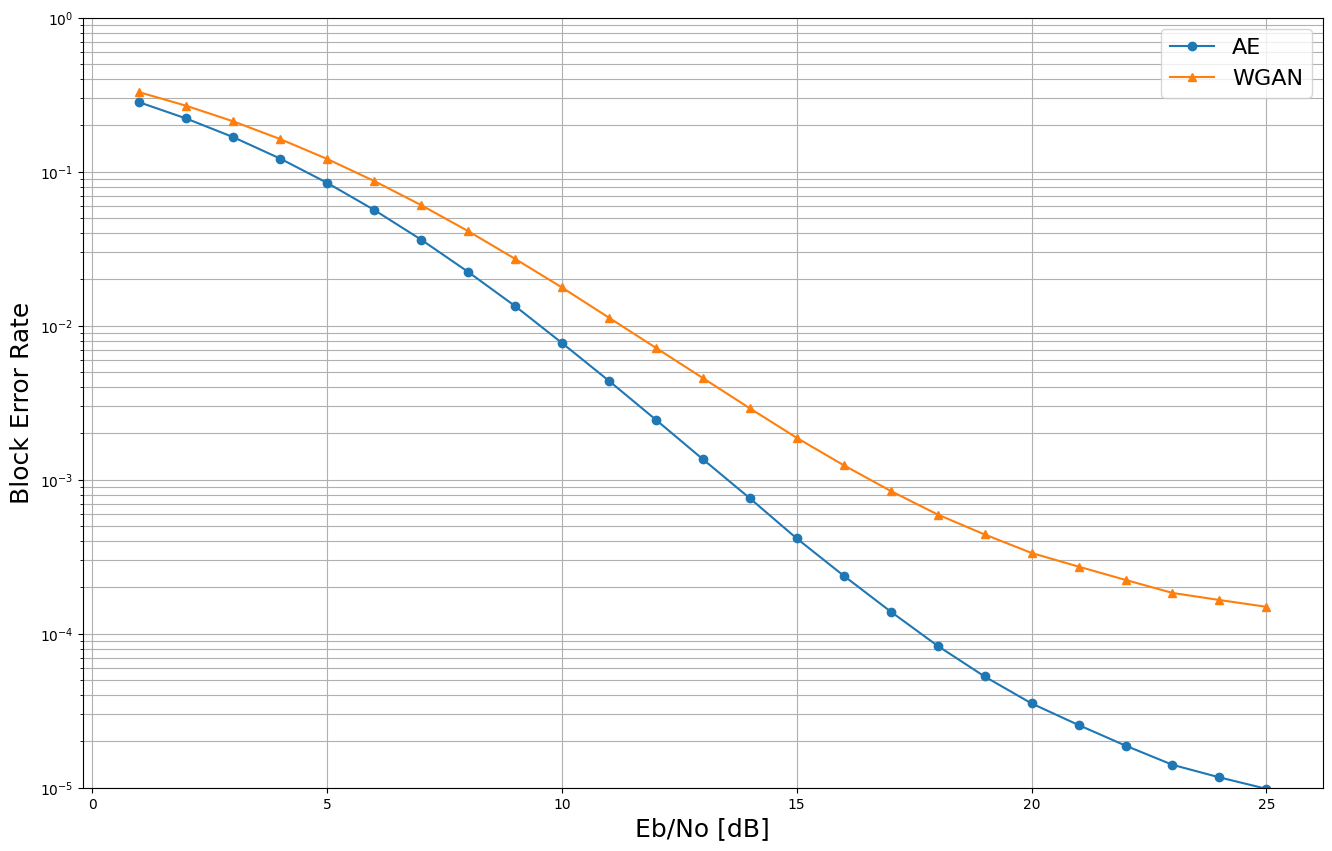

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 10))
# Plot Autoencoder
plt.semilogy(ebno_range, bler_testAE, 'o-')
#plt.semilogy(bber_data[0], bber_data[2], 'o-')
#plt.semilogy(bber_data[0], vec, 'o-')

plt.semilogy(ebno_range, bler_testGAN, '^-')

# Plot approx 16 QAM
#ebnodbs = np.linspace(5,14,10)
#a, _ = utils.MQAM_rayleigh_approx(16,ebnodbs)
#plt.plot(ebnodbs, a, '^-');

#b = [utils.rayleigh_error(t) for t in ebnodbs]
#plt.plot(ebnodbs, b, '^-');

#ebnodbs = np.linspace(0,11,22)
#uncoded_16QAM_Rayleigh_SER = [0.5501, 0.5040, 0.4564, 0.4082, 0.3606, 0.3147, 0.2713, 0.2313, 0.1951, 0.1631, 0.1352, 0.1112, 0.091, 0.07396, 0.05989, 0.04832, 0.03886, 0.03119, 0.02497, 0.01996, 0.01594, 0.01271]
#c = [(1-(1-t)**4) for t in uncoded_16QAM_Rayleigh_SER]
#plt.plot(ebnodbs, c, '^-');

plt.gca().set_ylim(1e-5, 1)
#plt.gca().set_xlim(5, 18)
plt.ylabel("Block Error Rate", fontsize=18, rotation=90)
plt.xlabel("Eb/No [dB]", fontsize=18)
plt.legend(['AE', 'WGAN'], prop={'size': 16}, loc='upper right');
plt.grid(True, which="both")
#plt.savefig('ae-ray-testing.pdf')

In [14]:
import pickle
data = (ebno_range, bler_testGAN)
with open('Rayleigh_WGAN.pkl', 'wb') as f:
    pickle.dump(data, f)